# Risk marker analysis - SHAP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV,RepeatedKFold, RepeatedStratifiedKFold, KFold, cross_val_score, StratifiedKFold, StratifiedShuffleSplit
import seaborn as sns
import os
import pickle
!pip3 install shap
import shap
shap.initjs()
import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_data(raw_clinical_note):
    data = pd.read_csv(raw_clinical_note, header=0,na_filter=True)
    return data

def delete_columns(data,columns): 
    df = data.drop(columns,axis=1)
    return df

def plot_shap_values(model,X,feature_list,title,name, logs_file):
    explainer = shap.TreeExplainer(model.best_estimator_)
    shap_values = explainer.shap_values(X)
    plt.title(title)
    fig_name = name + '.pdf'
    url_save = os.path.join(logs_file,str(fig_name))
    return shap.summary_plot(shap_values, X, feature_names=feature_list, plot_type='bar',max_display=10,show=False)
    plt.savefig(url_save, bbox_inches='tight')
    
def saving_model(model_ehr,model_name,logs_file):
    print("============= Saving model ================")
    file_out = os.path.join(logs_file,str(model_name))
    with open(file_out, 'wb') as modelfile:
        pickle.dump(model_ehr,modelfile)

In [3]:
raw_data = 'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/data_morelos_rename.csv'
data = pd.read_csv(raw_data)
print ("Total de registros", data.shape[0])

Total de registros 12103


In [4]:
X = data.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','LOCRESI','RECTRATA', 'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'CLASCOVID19','Evolution','FECINGRE', 'FECINISI','VIH-SIDA', 'Mortality'],axis=1).astype(int)
y = data['Mortality'].astype(int) 
y = y.values.reshape(y.shape[0],1) 
feature_list = X.columns
print("X::", X.shape)
print("Y::", y.shape)

X:: (12103, 39)
Y:: (12103, 1)


In [5]:
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Sex', 'LOCRESI',
       'Evolution', 'Intubated ', 'Age', 'Pregnancy', 'FECINGRE', 'FECINISI',
       'Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'VIH-SIDA',
       'Cardiovascular disease', 'Obesity', 'CKD', 'Smoking', 'RECTRATA',
       'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'Puerperium', 'Use of antipyretics',
       'ICU', 'CLASCOVID19', 'Days elapsed', 'HIV AIDS', 'Mortality'],
      dtype='object')

In [6]:
import joblib
XGB_loaded = joblib.load('C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/pkl/modelXGB1.pkl')

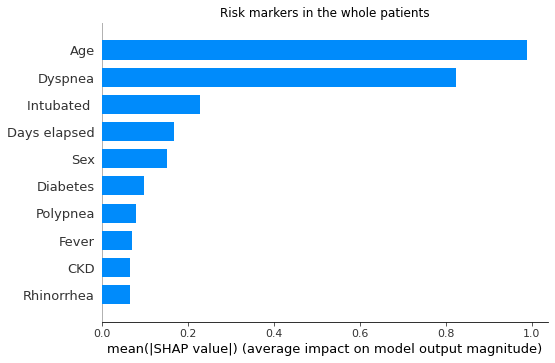

In [7]:
title = "Risk markers in the whole patients"
plot_shap_values(XGB_loaded,X,feature_list,title,"Risk markers in the whole patients",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito')
plt.savefig('Risk_markers_in_the_whole_patients' , format='pdf', bbox_inches='tight')

# Analysis men

In [8]:
data_hombres = data[(data["Sex"]==1)] 
X_hombre = data_hombres.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','LOCRESI','RECTRATA', 'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'CLASCOVID19','Evolution','FECINGRE', 'FECINISI','VIH-SIDA', 'Mortality','Sex','Pregnancy','Puerperium',],axis=1)
feature_list_hombres = X_hombre.columns
y_hombre = data_hombres['Mortality'].astype(int)
y_hombre = y_hombre.values.reshape(y_hombre.shape[0],1) 
print("X::", X_hombre.shape)
print("Y::", y_hombre.shape)
print(feature_list_hombres)

X:: (6605, 36)
Y:: (6605, 1)
Index(['Intubated ', 'Age', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea',
       'Irritability', 'Diarrhea', 'Chest pain', 'Chills', 'Headache',
       'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea', 'Polypnea',
       'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'ICU',
       'Days elapsed', 'HIV AIDS'],
      dtype='object')


In [9]:
def training(X,y,parameters,cv):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=242)
        
    ratio = float(np.sum(y_train == 0)) / np.sum(y_train==1)
    parameters=parameters
    sample_weights = np.ones(len(X_train))
    
    estimator = xgb.XGBClassifier(scale_pos_weight= ratio)
    
    grid = GridSearchCV(estimator=estimator, param_grid=parameters, cv = cv, scoring='roc_auc', refit = True)
    model = grid.fit(X_train,y_train,sample_weight = sample_weights)
    return model, X_test, y_test

[08:40:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:40:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:40:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[08:40:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:40:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:40:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

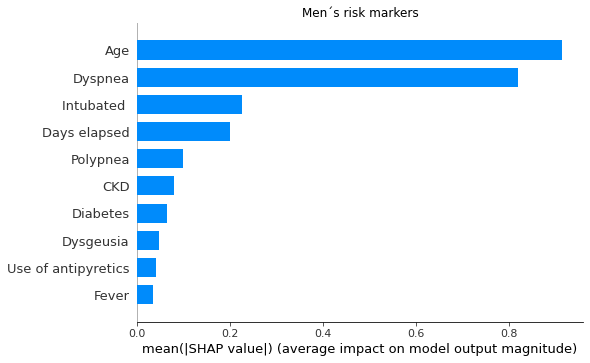

In [10]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=442)
model_hombres,X_test_hombre, y_test_hombre = training(X_hombre,y_hombre,parameters,cv)
plot_shap_values(model_hombres,X_hombre,feature_list_hombres,"Men´s risk markers","Men´s risk markers",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito')
plt.savefig('Men´s risk markers' , format='pdf', bbox_inches='tight')

In [11]:
saving_model(model_hombres,"modelXGB_men","C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/Modelos por sexo")

============= Saving model ================


In [12]:
feature_important_hombres = model_hombres.best_estimator_.feature_importances_
feature_important_hombres = np.reshape(feature_important_hombres,(1,X_hombre.shape[1]))
df_feature_hombres = pd.DataFrame(feature_important_hombres,columns = feature_list_hombres)

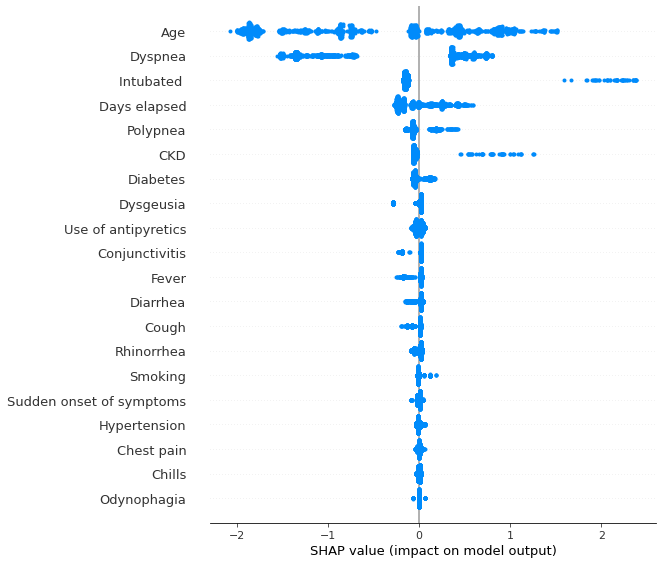

<Figure size 432x288 with 0 Axes>

In [13]:
explainer = shap.TreeExplainer(model_hombres.best_estimator_)
shap_values = explainer.shap_values(X_test_hombre)
shap.force_plot(explainer.expected_value, shap_values[200], X_test_hombre.iloc[200],show = True, feature_names=feature_list_hombres)
fig = shap.summary_plot(shap_values, feature_list_hombres)
plt.savefig('scratch.png')

# Analysis of men aged 20 to 29

In [14]:
data_hombres_edad_20_29 = data_hombres[(data_hombres["Age"]>=20) & ((data_hombres["Age"]<=29))]
X_hombre_edad_20_29 = data_hombres_edad_20_29.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','LOCRESI','RECTRATA', 'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'CLASCOVID19','Evolution','FECINGRE', 'FECINISI','VIH-SIDA', 'Mortality','Pregnancy','Puerperium','Sex', 'Age',],axis=1)
y_hombre_edad_20_29 = data_hombres_edad_20_29['Mortality'].astype(int)
y_hombre_edad_20_29 = y_hombre_edad_20_29.values.reshape(y_hombre_edad_20_29.shape[0],1)
feature_list_hombres_edad_20_29 = X_hombre_edad_20_29.columns
print("X::", X_hombre_edad_20_29.shape)
print("Y::", y_hombre_edad_20_29.shape)
print(feature_list_hombres_edad_20_29)

X:: (661, 35)
Y:: (661, 1)
Index(['Intubated ', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea',
       'Irritability', 'Diarrhea', 'Chest pain', 'Chills', 'Headache',
       'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea', 'Polypnea',
       'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'ICU',
       'Days elapsed', 'HIV AIDS'],
      dtype='object')


[08:41:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[08:41:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

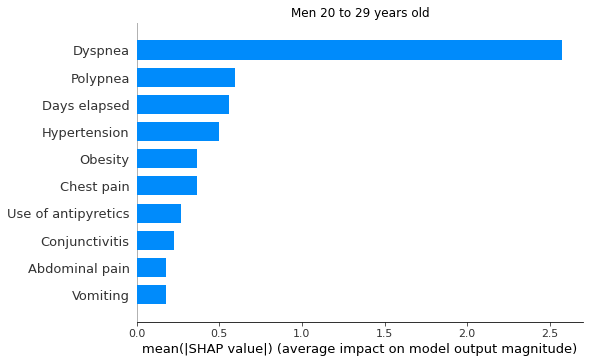

In [15]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=442)
model_hombres_edad_20_29,X_test_hombre_edad_20_29, y_test_hombre_edad_20_29 = training(X_hombre_edad_20_29,y_hombre_edad_20_29,parameters,cv)

title = "Men 20 to 29 years old"
plot_shap_values(model_hombres_edad_20_29,X_hombre_edad_20_29,feature_list_hombres_edad_20_29,title,"Men 20 to 29 years old",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito')
plt.savefig('Men 20 to 29 years old' , format='pdf', bbox_inches='tight')

# Analysis of men aged 30 to 39

In [16]:
data_hombres_edad_30_39 = data_hombres[(data_hombres["Age"]>=30) & ((data_hombres["Age"]<=39))]
X_hombre_edad_30_39 = data_hombres_edad_30_39.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','LOCRESI','RECTRATA', 'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'CLASCOVID19','Evolution','FECINGRE', 'FECINISI','VIH-SIDA', 'Mortality', 'Pregnancy','Puerperium','Sex','Age',],axis=1)
y_hombre_edad_30_39 = data_hombres_edad_30_39['Mortality'].astype(int)
y_hombre_edad_30_39 = y_hombre_edad_30_39.values.reshape(y_hombre_edad_30_39.shape[0],1)
feature_list_hombres_edad_30_39 = X_hombre_edad_30_39.columns
print("X::", X_hombre_edad_30_39.shape)
print("Y::", y_hombre_edad_30_39.shape)
print(feature_list_hombres_edad_30_39)

X:: (1115, 35)
Y:: (1115, 1)
Index(['Intubated ', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea',
       'Irritability', 'Diarrhea', 'Chest pain', 'Chills', 'Headache',
       'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea', 'Polypnea',
       'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'ICU',
       'Days elapsed', 'HIV AIDS'],
      dtype='object')


[08:41:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[08:41:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

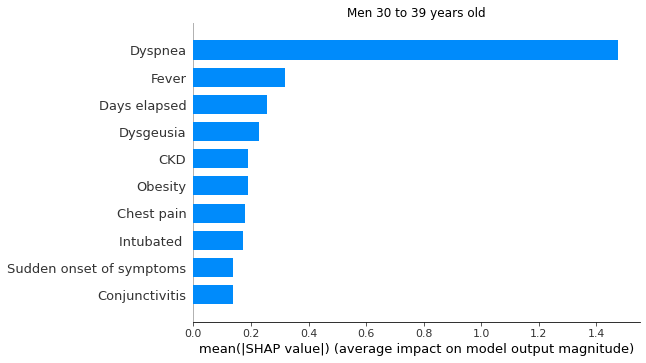

In [17]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=442)
model_hombres_edad_30_39,X_test_hombre_edad_30_39, y_test_hombre_edad_30_39 = training(X_hombre_edad_30_39,y_hombre_edad_30_39,parameters,cv)

title = "Men 30 to 39 years old"
plot_shap_values(model_hombres_edad_30_39,X_hombre_edad_30_39,feature_list_hombres_edad_30_39,title,"Men 30 to 39 years old",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito')
plt.savefig('Men 30 to 39 years old' , format='pdf', bbox_inches='tight')


# Analysis of men aged 40 to 49

In [18]:
data_hombres_edad_40_49 = data_hombres[(data_hombres["Age"]>=40) & ((data_hombres["Age"]<=49))] 
X_hombre_edad_40_49 = data_hombres_edad_40_49.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','LOCRESI','RECTRATA', 'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'CLASCOVID19','Evolution','FECINGRE', 'FECINISI','VIH-SIDA', 'Mortality', 'Pregnancy','Puerperium','Sex','Age',],axis=1)
y_hombre_edad_40_49 = data_hombres_edad_40_49['Mortality'].astype(int)
y_hombre_edad_40_49 = y_hombre_edad_40_49.values.reshape(y_hombre_edad_40_49.shape[0],1) 
feature_list_hombres_edad_40_49 = X_hombre_edad_40_49.columns
print("X::", X_hombre_edad_40_49.shape)
print("Y::", y_hombre_edad_40_49.shape)
print(feature_list_hombres_edad_40_49)

X:: (1206, 35)
Y:: (1206, 1)
Index(['Intubated ', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea',
       'Irritability', 'Diarrhea', 'Chest pain', 'Chills', 'Headache',
       'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea', 'Polypnea',
       'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'ICU',
       'Days elapsed', 'HIV AIDS'],
      dtype='object')


[08:41:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi


[08:41:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language b

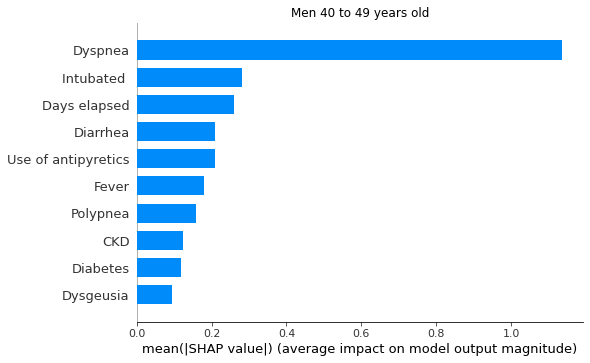

In [19]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=442)
model_hombres_edad_40_49,X_test_hombre_edad_40_49, y_test_hombre_edad_40_49 = training(X_hombre_edad_40_49,y_hombre_edad_40_49,parameters,cv)

title = "Men 40 to 49 years old"
plot_shap_values(model_hombres_edad_40_49,X_hombre_edad_40_49,feature_list_hombres_edad_40_49,title,"Men 40 to 49 years old",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito')
plt.savefig('Men 40 to 49 years old' , format='pdf', bbox_inches='tight')

# Analysis of men aged 50 to 59

In [20]:
data_hombres_edad_50_59 = data_hombres[(data_hombres["Age"]>=50) & ((data_hombres["Age"]<=59))] 
X_hombre_edad_50_59 = data_hombres_edad_50_59.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','LOCRESI','RECTRATA', 'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'CLASCOVID19','Evolution','FECINGRE', 'FECINISI','VIH-SIDA', 'Mortality', 'Pregnancy','Puerperium','Sex','Age',],axis=1)
y_hombre_edad_50_59 = data_hombres_edad_50_59['Mortality'].astype(int)
y_hombre_edad_50_59 = y_hombre_edad_50_59.values.reshape(y_hombre_edad_50_59.shape[0],1) 
feature_list_hombres_edad_50_59 = X_hombre_edad_50_59.columns
print("X::", X_hombre_edad_50_59.shape)
print("Y::", y_hombre_edad_50_59.shape)
print(feature_list_hombres_edad_50_59)

X:: (1240, 35)
Y:: (1240, 1)
Index(['Intubated ', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea',
       'Irritability', 'Diarrhea', 'Chest pain', 'Chills', 'Headache',
       'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea', 'Polypnea',
       'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'ICU',
       'Days elapsed', 'HIV AIDS'],
      dtype='object')


[08:41:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[08:41:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

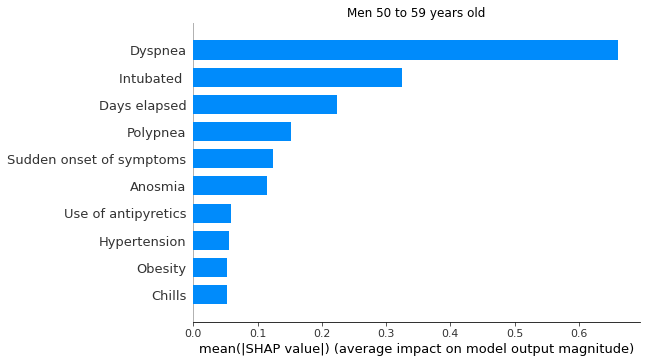

In [21]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=442)
model_hombres_edad_50_59,X_test_hombre_edad_50_59, y_test_hombre_edad_50_59 = training(X_hombre_edad_50_59,y_hombre_edad_50_59,parameters,cv)

title = "Men 50 to 59 years old"
plot_shap_values(model_hombres_edad_50_59,X_hombre_edad_50_59,feature_list_hombres_edad_50_59,title, "Men 50 to 59 years old",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito')
plt.savefig('Men 50 to 59 years old' , format='pdf', bbox_inches='tight')

# Analysis of men aged 60 to 69

In [22]:
data_hombres_edad_60_69 = data_hombres[(data_hombres["Age"]>=60) & ((data_hombres["Age"]<=69))]
X_hombre_edad_60_69 = data_hombres_edad_60_69.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','LOCRESI','RECTRATA', 'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'CLASCOVID19','Evolution','FECINGRE', 'FECINISI','VIH-SIDA', 'Mortality', 'Pregnancy','Puerperium','Sex','Age',],axis=1)
y_hombre_edad_60_69 = data_hombres_edad_60_69['Mortality'].astype(int)
y_hombre_edad_60_69 = y_hombre_edad_60_69.values.reshape(y_hombre_edad_60_69.shape[0],1)
feature_list_hombres_edad_60_69 = X_hombre_edad_60_69.columns
print("X::", X_hombre_edad_60_69.shape)
print("Y::", y_hombre_edad_60_69.shape)
print(feature_list_hombres_edad_60_69)

X:: (1127, 35)
Y:: (1127, 1)
Index(['Intubated ', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea',
       'Irritability', 'Diarrhea', 'Chest pain', 'Chills', 'Headache',
       'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea', 'Polypnea',
       'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'ICU',
       'Days elapsed', 'HIV AIDS'],
      dtype='object')


[08:41:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi


[08:41:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language b

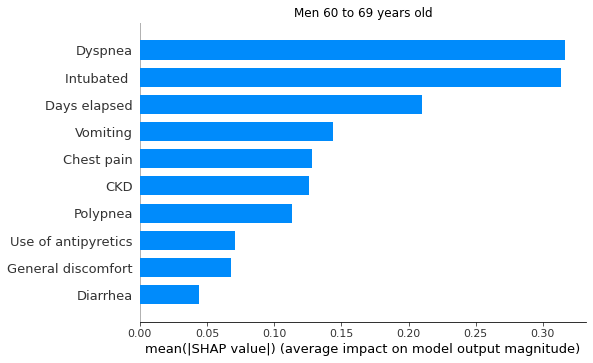

In [23]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=442)
model_hombres_edad_60_69,X_test_hombre_edad_60_69, y_test_hombre_edad_60_69 = training(X_hombre_edad_60_69,y_hombre_edad_60_69,parameters,cv)

title = "Men 60 to 69 years old"
plot_shap_values(model_hombres_edad_60_69,X_hombre_edad_60_69,feature_list_hombres_edad_60_69,title,"Men 60 to 69 years old",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito')
plt.savefig('Men 60 to 69 years old' , format='pdf', bbox_inches='tight')

# Analysis of men aged 70 and over

In [24]:
data_hombres_edad_70 = data_hombres[(data_hombres["Age"]>=70)]
X_hombre_edad_70 = data_hombres_edad_70.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','LOCRESI','RECTRATA', 'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'CLASCOVID19','Evolution','FECINGRE', 'FECINISI','VIH-SIDA','Mortality','Pregnancy','Puerperium','Sex','Age',],axis=1)
y_hombre_edad_70 = data_hombres_edad_70['Mortality'].astype(int)
y_hombre_edad_70 = y_hombre_edad_70.values.reshape(y_hombre_edad_70.shape[0],1)
feature_list_hombres_edad_70 = X_hombre_edad_70.columns
print("X::", X_hombre_edad_70.shape)
print("Y::", y_hombre_edad_70.shape)
print(feature_list_hombres_edad_70)

X:: (1121, 35)
Y:: (1121, 1)
Index(['Intubated ', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea',
       'Irritability', 'Diarrhea', 'Chest pain', 'Chills', 'Headache',
       'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea', 'Polypnea',
       'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'ICU',
       'Days elapsed', 'HIV AIDS'],
      dtype='object')


[08:41:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[08:41:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

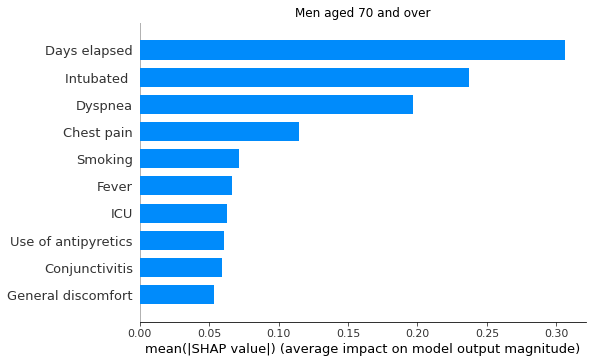

In [25]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=442)
model_hombres_edad_70,X_test_hombre_edad_70, y_test_hombre_edad_70 = training(X_hombre_edad_70,y_hombre_edad_70,parameters,cv)

title = "Men aged 70 and over"
plot_shap_values(model_hombres_edad_70,X_hombre_edad_70,feature_list_hombres_edad_70,title,"Men 70 to 79 years old",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito')
plt.savefig('Men 70 to 79 years old' , format='pdf', bbox_inches='tight')

# Analysis women

In [26]:
data_mujer = data[(data["Sex"]==0)] 
X_mujer = data_mujer.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','LOCRESI','RECTRATA', 'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'CLASCOVID19','Evolution','FECINGRE', 'FECINISI','VIH-SIDA', 'Mortality','Sex',],axis=1)
y_mujer = data_mujer['Mortality'].astype(int)
y_mujer = y_mujer.values.reshape(y_mujer.shape[0],1) 
feature_list_mujer = X_mujer.columns
print("X::", X_mujer.shape)
print("Y::", y_mujer.shape)
print(feature_list_mujer)

X:: (5498, 38)
Y:: (5498, 1)
Index(['Intubated ', 'Age', 'Pregnancy', 'Fever', 'Cough', 'Odynophagia',
       'Dyspnea', 'Irritability', 'Diarrhea', 'Chest pain', 'Chills',
       'Headache', 'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea',
       'Polypnea', 'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Puerperium', 'Use of antipyretics', 'ICU',
       'Days elapsed', 'HIV AIDS'],
      dtype='object')


[08:41:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[08:41:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

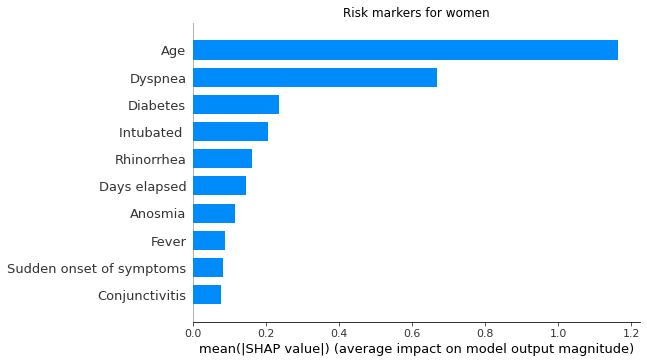

In [27]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=442)
model_mujer,X_test_mujer, y_test_mujer = training(X_mujer,y_mujer,parameters,cv)

title = "Risk markers for women"
plot_shap_values(model_mujer,X_mujer,feature_list_mujer,title,"Women´s risk markers",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito')
plt.savefig('Risk markers for women', format='pdf', bbox_inches='tight')

In [28]:
saving_model(model_mujer,"modelXGB_women","C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/Modelos por sexo")

============= Saving model ================


# Analysis of women aged 20 to 29

In [29]:
data_mujeres_edad_20_29 = data_mujer[(data_mujer["Age"]>=20) & ((data_mujer["Age"]<=29))]
X_mujer_edad_20_29 = data_mujeres_edad_20_29.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','LOCRESI','RECTRATA', 'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'CLASCOVID19','Evolution','FECINGRE', 'FECINISI','VIH-SIDA', 'Mortality','Sex','Age',],axis=1)
y_mujer_edad_20_29 = data_mujeres_edad_20_29['Mortality'].astype(int)
y_mujer_edad_20_29 = y_mujer_edad_20_29.values.reshape(y_mujer_edad_20_29.shape[0],1)
feature_list_mujeres_edad_20_29 = X_mujer_edad_20_29.columns
print("X::", X_mujer_edad_20_29.shape)
print("Y::", y_mujer_edad_20_29.shape)
print(feature_list_mujeres_edad_20_29)

X:: (701, 37)
Y:: (701, 1)
Index(['Intubated ', 'Pregnancy', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea',
       'Irritability', 'Diarrhea', 'Chest pain', 'Chills', 'Headache',
       'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea', 'Polypnea',
       'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Puerperium', 'Use of antipyretics', 'ICU',
       'Days elapsed', 'HIV AIDS'],
      dtype='object')


# Analysis of women aged 30 to 39

In [30]:
data_mujeres_edad_30_39 = data_mujer[(data_mujer["Age"]>=30) & ((data_mujer["Age"]<=39))]
X_mujer_edad_30_39 = data_mujeres_edad_30_39.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','LOCRESI','RECTRATA', 'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'CLASCOVID19','Evolution','FECINGRE', 'FECINISI','VIH-SIDA', 'Mortality','Sex','Age',],axis=1)
y_mujer_edad_30_39 = data_mujeres_edad_30_39['Mortality'].astype(int)
y_mujer_edad_30_39 = y_mujer_edad_30_39.values.reshape(y_mujer_edad_30_39.shape[0],1)
feature_list_mujeres_edad_30_39 = X_mujer_edad_30_39.columns
print("X::", X_mujer_edad_30_39.shape)
print("Y::", y_mujer_edad_30_39.shape)
print(feature_list_mujeres_edad_30_39)

X:: (1143, 37)
Y:: (1143, 1)
Index(['Intubated ', 'Pregnancy', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea',
       'Irritability', 'Diarrhea', 'Chest pain', 'Chills', 'Headache',
       'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea', 'Polypnea',
       'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Puerperium', 'Use of antipyretics', 'ICU',
       'Days elapsed', 'HIV AIDS'],
      dtype='object')


[08:41:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[08:41:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

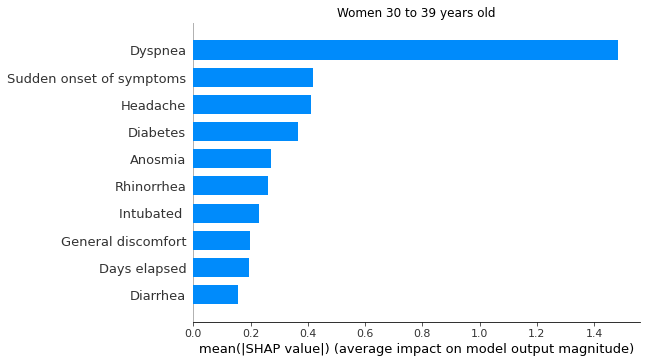

In [31]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=442)
model_mujeres_edad_30_39,X_test_mujer_edad_30_39, y_test_mujer_edad_30_39 = training(X_mujer_edad_30_39,y_mujer_edad_30_39,parameters,cv)

title = "Women 30 to 39 years old"
plot_shap_values(model_mujeres_edad_30_39,X_mujer_edad_30_39,feature_list_mujeres_edad_30_39,title,"Women 30 to 39 years old",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito')
plt.savefig('Women 30 to 39 years old', format='pdf', bbox_inches='tight')

# Analysis of women aged 40 to 49

In [32]:
data_mujeres_edad_40_49 = data_mujer[(data_mujer["Age"]>=40) & ((data_mujer["Age"]<=49))]
X_mujer_edad_40_49 = data_mujeres_edad_40_49.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','LOCRESI','RECTRATA', 'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'CLASCOVID19','Evolution','FECINGRE', 'FECINISI','VIH-SIDA', 'Mortality','Sex','Age',],axis=1)
y_mujer_edad_40_49 = data_mujeres_edad_40_49['Mortality'].astype(int)
y_mujer_edad_40_49 = y_mujer_edad_40_49.values.reshape(y_mujer_edad_40_49.shape[0],1)
feature_list_mujeres_edad_40_49 = X_mujer_edad_40_49.columns
print("X::", X_mujer_edad_40_49.shape)
print("Y::", y_mujer_edad_40_49.shape)
print(feature_list_mujeres_edad_40_49)

X:: (1090, 37)
Y:: (1090, 1)
Index(['Intubated ', 'Pregnancy', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea',
       'Irritability', 'Diarrhea', 'Chest pain', 'Chills', 'Headache',
       'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea', 'Polypnea',
       'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Puerperium', 'Use of antipyretics', 'ICU',
       'Days elapsed', 'HIV AIDS'],
      dtype='object')


[08:41:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[08:41:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

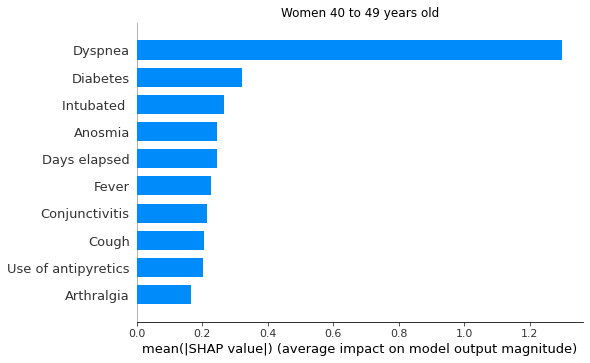

In [33]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=442)
model_mujeres_edad_40_49,X_test_mujer_edad_40_49, y_test_mujer_edad_40_49 = training(X_mujer_edad_40_49,y_mujer_edad_40_49,parameters,cv)

title = "Women 40 to 49 years old"
plot_shap_values(model_mujeres_edad_40_49,X_mujer_edad_40_49,feature_list_mujeres_edad_40_49,title,"Women 40 to 49 years old",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito')
plt.savefig('Women 40 to 49 years old', format='pdf', bbox_inches='tight')


# Analysis of women aged 50 to 59

In [34]:
data_mujeres_edad_50_59 = data_mujer[(data_mujer["Age"]>=50) & ((data_mujer["Age"]<=59))]
X_mujer_edad_50_59 = data_mujeres_edad_50_59.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','LOCRESI','RECTRATA', 'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'CLASCOVID19','Evolution','FECINGRE', 'FECINISI','VIH-SIDA', 'Mortality','Sex','Age',],axis=1)
y_mujer_edad_50_59 = data_mujeres_edad_50_59['Mortality'].astype(int)
y_mujer_edad_50_59 = y_mujer_edad_50_59.values.reshape(y_mujer_edad_50_59.shape[0],1)
feature_list_mujeres_edad_50_59 = X_mujer_edad_50_59.columns
print("X::", X_mujer_edad_50_59.shape)
print("Y::", y_mujer_edad_50_59.shape)
print(feature_list_mujeres_edad_50_59)

X:: (994, 37)
Y:: (994, 1)
Index(['Intubated ', 'Pregnancy', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea',
       'Irritability', 'Diarrhea', 'Chest pain', 'Chills', 'Headache',
       'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea', 'Polypnea',
       'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Puerperium', 'Use of antipyretics', 'ICU',
       'Days elapsed', 'HIV AIDS'],
      dtype='object')


[08:41:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[08:41:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

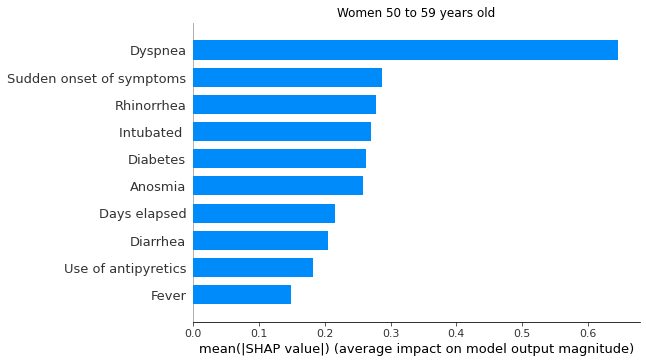

In [35]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=442)
model_mujeres_edad_50_59,X_test_mujer_edad_50_59, y_test_mujer_edad_50_59 = training(X_mujer_edad_50_59,y_mujer_edad_50_59,parameters,cv)

title = "Women 50 to 59 years old"
plot_shap_values(model_mujeres_edad_50_59,X_mujer_edad_50_59,feature_list_mujeres_edad_50_59,title,"Women 50 to 59 years old",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito')
plt.savefig('Women 50 to 59 years old', format='pdf', bbox_inches='tight')


# Analysis of women aged 60 to 69

In [36]:
data_mujeres_edad_60_69 = data_mujer[(data_mujer["Age"]>=60) & ((data_mujer["Age"]<=69))]
X_mujer_edad_60_69 = data_mujeres_edad_60_69.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','LOCRESI','RECTRATA', 'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'CLASCOVID19','Evolution','FECINGRE', 'FECINISI','VIH-SIDA', 'Mortality','Sex','Age',],axis=1)
y_mujer_edad_60_69 = data_mujeres_edad_60_69['Mortality'].astype(int)
y_mujer_edad_60_69 = y_mujer_edad_60_69.values.reshape(y_mujer_edad_60_69.shape[0],1) 
feature_list_mujeres_edad_60_69 = X_mujer_edad_60_69.columns
print("X::", X_mujer_edad_60_69.shape)
print("Y::", y_mujer_edad_60_69.shape)
print(feature_list_mujeres_edad_60_69)

X:: (749, 37)
Y:: (749, 1)
Index(['Intubated ', 'Pregnancy', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea',
       'Irritability', 'Diarrhea', 'Chest pain', 'Chills', 'Headache',
       'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea', 'Polypnea',
       'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Puerperium', 'Use of antipyretics', 'ICU',
       'Days elapsed', 'HIV AIDS'],
      dtype='object')


[08:41:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[08:41:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

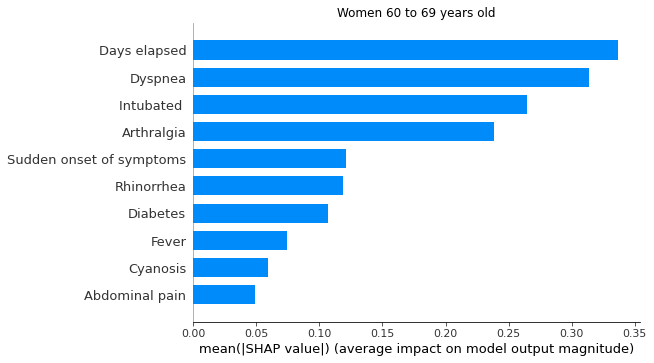

In [37]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=442)
model_mujeres_edad_60_69,X_test_mujer_edad_60_69, y_test_mujer_edad_60_69 = training(X_mujer_edad_60_69,y_mujer_edad_60_69,parameters,cv)

title = "Women 60 to 69 years old"
plot_shap_values(model_mujeres_edad_60_69,X_mujer_edad_60_69,feature_list_mujeres_edad_60_69,title,"Women 60 to 69 years old",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito')
plt.savefig('Women 60 to 69 years old', format='pdf', bbox_inches='tight')

# Analysis of women aged 70 and over

In [38]:
data_mujeres_edad_70 = data_mujer[(data_mujer["Age"]>=70)]
X_mujer_edad_70 = data_mujeres_edad_70.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','LOCRESI','RECTRATA', 'TXCROBIA', 'TXANTIVI', 'RESDEFIN', 'CLASCOVID19','Evolution','FECINGRE', 'FECINISI','VIH-SIDA', 'Mortality','Sex','Age',],axis=1)
y_mujer_edad_70 = data_mujeres_edad_70['Mortality'].astype(int)
y_mujer_edad_70 = y_mujer_edad_70.values.reshape(y_mujer_edad_70.shape[0],1) 
feature_list_mujeres_edad_70 = X_mujer_edad_70.columns
print("X::", X_mujer_edad_70.shape)
print("Y::", y_mujer_edad_70.shape)
print(feature_list_mujeres_edad_70)

X:: (678, 37)
Y:: (678, 1)
Index(['Intubated ', 'Pregnancy', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea',
       'Irritability', 'Diarrhea', 'Chest pain', 'Chills', 'Headache',
       'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea', 'Polypnea',
       'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Puerperium', 'Use of antipyretics', 'ICU',
       'Days elapsed', 'HIV AIDS'],
      dtype='object')


[08:41:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[08:41:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:41:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bi

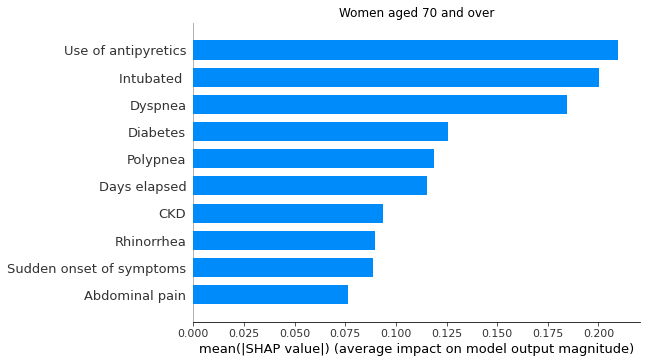

In [39]:
parameters={"n_estimators":[200],
            "learning_rate": [0.05],
            "objective": ['binary:logistic'], 
            "max_depth":[2],
            "seed": [422], 
            "eval_metric": ['auc'],
            "rate_drop": [0.1]}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=442)
model_mujeres_edad_70,X_test_mujer_edad_70, y_test_mujer_edad_70 = training(X_mujer_edad_70,y_mujer_edad_70,parameters,cv)

title = "Women aged 70 and over"
plot_shap_values(model_mujeres_edad_70,X_mujer_edad_70,feature_list_mujeres_edad_70,title,"Women 70 to 79 years old",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito')
plt.savefig('Women aged 70 and over', format='pdf', bbox_inches='tight')